In [7]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
import os
from scipy.stats import zscore
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import shap
import lime
from PyALE import ale
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.style as style
#style.available
style.use('tableau-colorblind10')
# style.use('seaborn-notebook')
style.use('seaborn-whitegrid')

random_state = 1000

In [8]:
def save_plot(figname: str):
    figname = figname+'.jpg'
    figdir = os.getcwd()
    filedir = '\\'.join([figdir, figname])
    plt.savefig(filedir, bbox_inches='tight', pad_inches=0, transparent=True)
    return

In [9]:
df = pd.read_csv('../data/rock_data.csv')

# handle missing values
if df.isnull().values.any():
    df.fillna(df.mean(), inplace=True)
    print('Missing values filled with mean.')

# detect and remove outliers

# drop highly correlated features
df.drop(['Area', 'Perimeter','Median Height', 'Max Height', 'STD Height'], axis=1, inplace=True)
df.columns

Index(['Sample ID', 'Rock ID', 'Class', 'Orientation', 'Axis Major Length',
       'Axis Minor Length', 'Mean Height', 'Mean Gradient', 'STD Gradient',
       'Gradient at Max', 'Weighted Hu Moment 1', 'Weighted Hu Moment 2',
       'Weighted Hu Moment 3', 'Weighted Hu Moment 4'],
      dtype='object')

In [10]:
X = df.iloc[:,3:].to_numpy(dtype=float)

def map_class_values(x):
    mapping = {12: 0, 58: 1, 34: 2}
    return mapping.get(x,None)

y = np.vectorize(map_class_values)(df['Class'].values)

In [11]:
# training:validation:testing = 60:20:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)

In [18]:
model_names = ['KNN', 'SVC', 'RF', 'XGB', 'TREE', 'MLP']
models = [KNeighborsClassifier(), SVC(), RandomForestClassifier(), XGBClassifier(), DecisionTreeClassifier(), MLPClassifier(max_iter=500)]
grid_params = [{'n_neighbors': [5, 10, 15, 20], 'weights': ['uniform', 'distance']}, {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'sigmoid']}, {'n_estimators': [10, 100, 200], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_features': ['sqrt', 'log2', None]}, {'max_depth': [3,5,7], 'n_estimators': [10, 100, 200], 'reg_lambda': [1e-3, 1, 1e3]}, {'criterion': ['gini', 'entropy', 'log_loss'],'max_depth': [3,5,7]}, {'hidden_layer_sizes': [(100,), (100,50), (100,50,100)], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'alpha': [1e-3, 1, 1e3]}]

In [13]:
def parse_report(y_val, model_best_pred, m, model_names, grid_search, dataset, opt_method):
    """
    Parse classification report valeus to dataframe for posterior comparison of model performance.
    Returns:
    --------
    df: classification report values dataframe
    """
    report = classification_report(y_val, model_best_pred, output_dict=True)
    dict_values = {}
    dict_values['model']=model_names[m]
    dict_values['params']=np.array([grid_search.best_params_])
    dict_values['dataset']=dataset
    dict_values['opt_method']=opt_method
    for elem, score in report.items():
        try:
            for score_name, score_num in score.items():
                if elem.isnumeric():
                    col_i = '_'.join(['class', elem.replace(" ", "_"), score_name])
                else:
                    col_i = '_'.join([elem.replace(" ", "_"), score_name])
                dict_values[col_i] = score_num
#                 col = np.append(col, col_i)
        except:
            col_i = elem
            dict_values[col_i] = score_num
#             col = np.append(col, col_i)
            continue
    df = pd.DataFrame(dict_values, index=[m])
    return df

KNN with {'n_neighbors': 15, 'weights': 'distance'} 
               precision    recall  f1-score   support

           0       0.77      0.84      0.80        88
           1       0.51      0.39      0.44        54
           2       0.74      0.79      0.76        76

    accuracy                           0.71       218
   macro avg       0.67      0.67      0.67       218
weighted avg       0.70      0.71      0.70       218




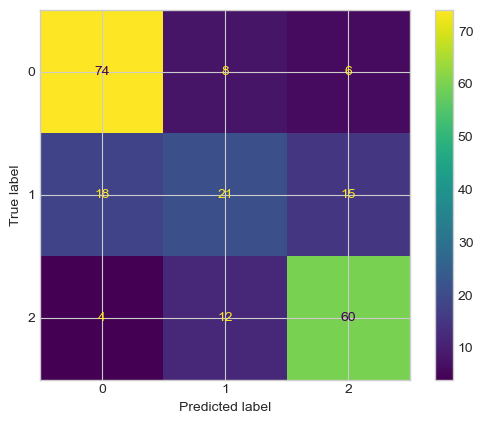

SVC with {'C': 10, 'kernel': 'rbf'} 
               precision    recall  f1-score   support

           0       0.77      0.82      0.80        88
           1       0.45      0.54      0.49        54
           2       0.80      0.63      0.71        76

    accuracy                           0.68       218
   macro avg       0.67      0.66      0.66       218
weighted avg       0.70      0.68      0.69       218




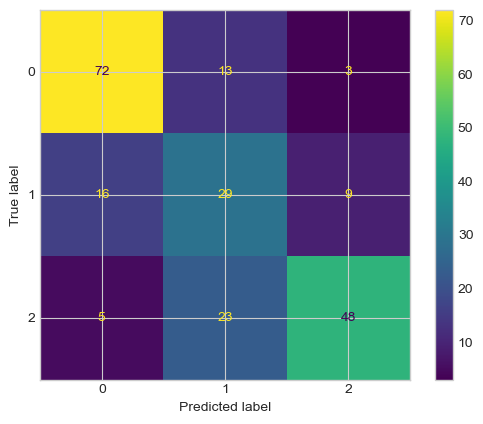

RF with {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 100} 
               precision    recall  f1-score   support

           0       0.78      0.82      0.80        88
           1       0.47      0.54      0.50        54
           2       0.78      0.66      0.71        76

    accuracy                           0.69       218
   macro avg       0.68      0.67      0.67       218
weighted avg       0.70      0.69      0.70       218




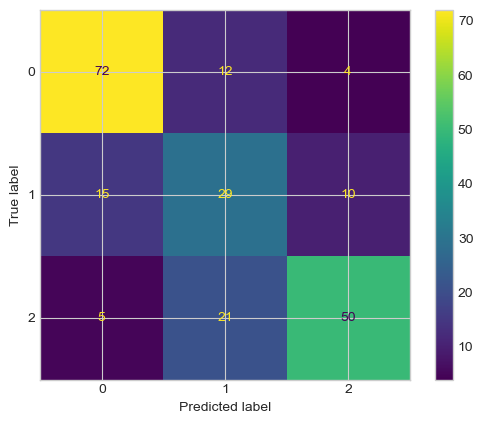

[14:16:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:06] WARNI

[14:16:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:11] WARNI

[14:16:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:21] WARNI

[14:16:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:29] WARNI

[14:16:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:38] WARNI

[14:16:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:49] WARNI

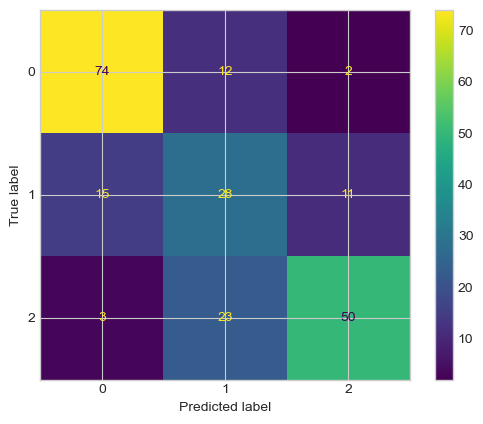

MLP with {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50)} 
               precision    recall  f1-score   support

           0       0.76      0.77      0.77        88
           1       0.48      0.37      0.42        54
           2       0.74      0.84      0.79        76

    accuracy                           0.70       218
   macro avg       0.66      0.66      0.66       218
weighted avg       0.68      0.70      0.69       218




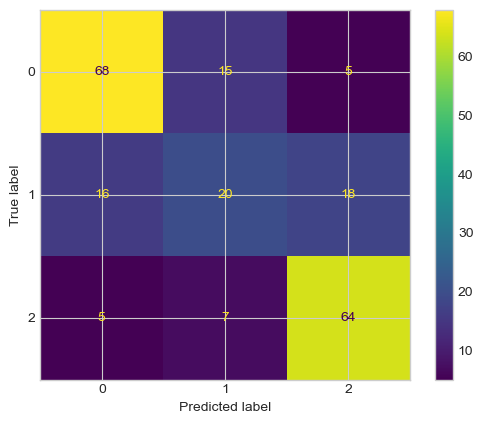

TREE with {'criterion': 'gini', 'max_depth': 5} 
               precision    recall  f1-score   support

           0       0.76      0.74      0.75        88
           1       0.37      0.56      0.44        54
           2       0.79      0.54      0.64        76

    accuracy                           0.62       218
   macro avg       0.64      0.61      0.61       218
weighted avg       0.68      0.62      0.64       218




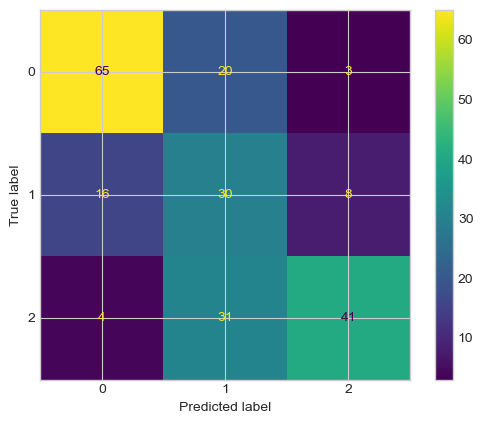

In [14]:
dataset = 'mean_height'
opt_method = 'grid_search'
for m,model in enumerate(models):
    grid_search = GridSearchCV(model, grid_params[m], cv=5)
    grid_search.fit(X_train, y_train)
    model_best = grid_search.best_estimator_
    model_best_pred = model_best.predict(X_val)
    # Parse report to dataframe to compare results among models
    if m==0:
        results_df = parse_report(y_val, model_best_pred, m, model_names, grid_search, dataset, opt_method)
    else:
        df_i = parse_report(y_val, model_best_pred, m, model_names, grid_search, dataset, opt_method)
        results_df = pd.concat([results_df, df_i])
    # Print results
    print(f'{model_names[m]} with {grid_search.best_params_} \n {classification_report(y_val, model_best_pred)}\n')
    ConfusionMatrixDisplay(confusion_matrix(y_val, model_best_pred)).plot()
    show()

## Bayes Search Optimization

In [19]:
search_spaces = [{
    'n_neighbors': Integer(3,50),
    'weights': Categorical(['uniform', 'distance'])
    },
    
    {
    'C': Real(0.1, 10, 'log-uniform'),
    'kernel': Categorical(['linear', 'rbf', 'sigmoid']),
    },
    
    {
    'n_estimators': Integer(10,200),
    'criterion': Categorical(['gini', 'entropy', 'log_loss']),
    'max_features': Categorical(['sqrt', 'log2', None]),
    },
    
    {
    'max_depth': Integer(3,10),
    'n_estimators': Integer(10,200),
    'reg_lambda': Real(1e-3, 1e3, 'log-uniform'),
    },
    {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3,5,7]
    }
    ]

KNN with OrderedDict([('n_neighbors', 19), ('weights', 'distance')]) 
               precision    recall  f1-score   support

           0       0.77      0.85      0.81        88
           1       0.46      0.39      0.42        54
           2       0.71      0.70      0.70        76

    accuracy                           0.68       218
   macro avg       0.65      0.65      0.64       218
weighted avg       0.67      0.68      0.68       218




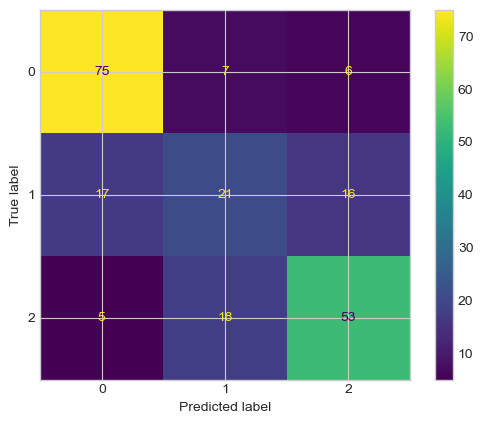

SVC with OrderedDict([('C', 10.0), ('kernel', 'rbf')]) 
               precision    recall  f1-score   support

           0       0.77      0.82      0.80        88
           1       0.45      0.54      0.49        54
           2       0.80      0.63      0.71        76

    accuracy                           0.68       218
   macro avg       0.67      0.66      0.66       218
weighted avg       0.70      0.68      0.69       218




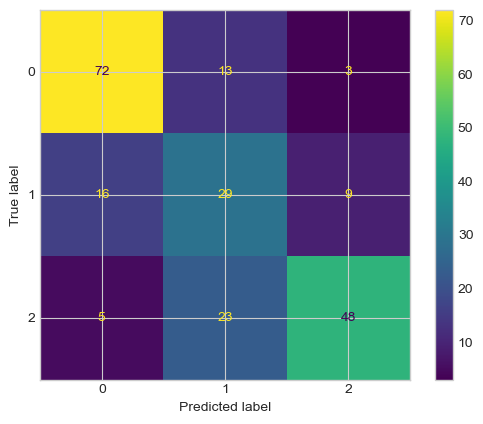

RF with OrderedDict([('criterion', 'log_loss'), ('max_features', 'sqrt'), ('n_estimators', 200)]) 
               precision    recall  f1-score   support

           0       0.78      0.84      0.81        88
           1       0.46      0.50      0.48        54
           2       0.78      0.66      0.71        76

    accuracy                           0.69       218
   macro avg       0.67      0.67      0.67       218
weighted avg       0.70      0.69      0.69       218




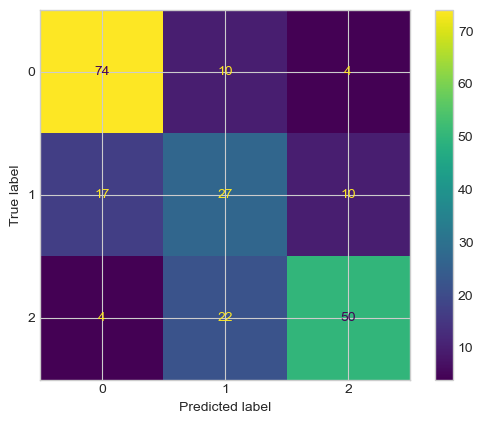

[14:42:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB with OrderedDict([('max_depth', 8), ('n_estimators', 79), ('reg_lambda', 0.0026800852025445953)]) 
               precision    recall  f1-score   support

           0       0.78      0.81      0.79        88
           1       0.45      0.54      0.49        54
           2       0.79      0.66      0.72        76

    accuracy                           0.69       218
   macro avg       0.68      0.67      0.67       218
weighted avg       0.70      0.69      0.69       218




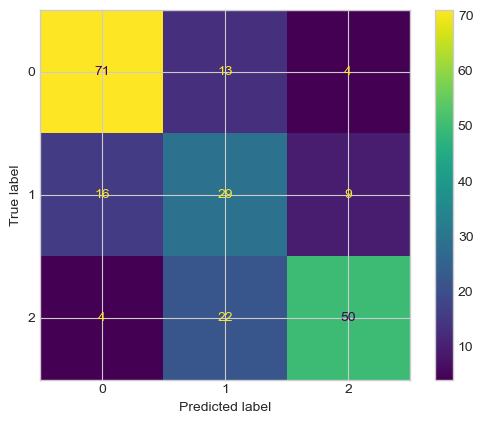

TREE with OrderedDict([('criterion', 'gini'), ('max_depth', 5)]) 
               precision    recall  f1-score   support

           0       0.76      0.74      0.75        88
           1       0.38      0.56      0.45        54
           2       0.77      0.54      0.64        76

    accuracy                           0.62       218
   macro avg       0.64      0.61      0.61       218
weighted avg       0.67      0.62      0.64       218




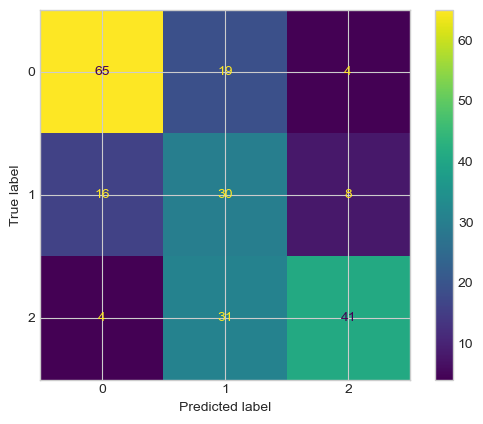

In [20]:
dataset = 'mean_height'
opt_method = 'bayes_search'
for m,model in enumerate(models[:-1]):
    bayes_search = BayesSearchCV(model, search_spaces[m], n_iter=50, cv=5, n_jobs=-1)
    bayes_search.fit(X_train, y_train)
    model_best = bayes_search.best_estimator_
    model_best_pred = model_best.predict(X_val)
    # Parse report to dataframe to compare results among models
    df_i = parse_report(y_val, model_best_pred, m, model_names, bayes_search, dataset, opt_method)
    results_df = pd.concat([results_df, df_i])
    print(f'{model_names[m]} with {bayes_search.best_params_} \n {classification_report(y_val, model_best_pred)}\n')
    ConfusionMatrixDisplay(confusion_matrix(y_val, model_best_pred)).plot()
    show()

In [21]:
best_models = [KNeighborsClassifier(n_neighbors=15, weights= 'distance'), SVC(C=10, kernel='rbf'), RandomForestClassifier(criterion='log_loss', max_features= 'sqrt', n_estimators=200), XGBClassifier(max_depth=3, n_estimators=100, reg_lambda=1), MLPClassifier(max_iter=500, activation='logistic', alpha=0.001, hidden_layer_sizes=(100,50))]

KNeighborsClassifier(n_neighbors=15, weights='distance') 
               precision    recall  f1-score   support

           0       0.71      0.88      0.79        74
           1       0.66      0.51      0.58        68
           2       0.74      0.72      0.73        76

    accuracy                           0.71       218
   macro avg       0.71      0.71      0.70       218
weighted avg       0.71      0.71      0.70       218




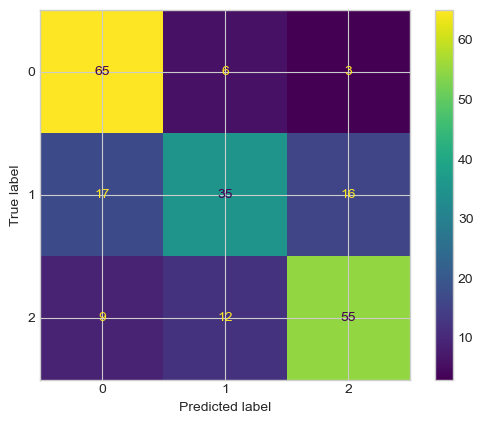

SVC(C=10) 
               precision    recall  f1-score   support

           0       0.70      0.86      0.78        74
           1       0.59      0.51      0.55        68
           2       0.75      0.67      0.71        76

    accuracy                           0.69       218
   macro avg       0.68      0.68      0.68       218
weighted avg       0.69      0.69      0.68       218




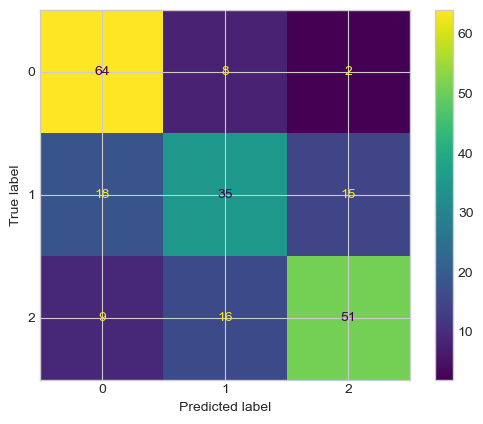

RandomForestClassifier(criterion='log_loss', n_estimators=200) 
               precision    recall  f1-score   support

           0       0.72      0.85      0.78        74
           1       0.61      0.56      0.58        68
           2       0.74      0.66      0.69        76

    accuracy                           0.69       218
   macro avg       0.69      0.69      0.69       218
weighted avg       0.69      0.69      0.69       218




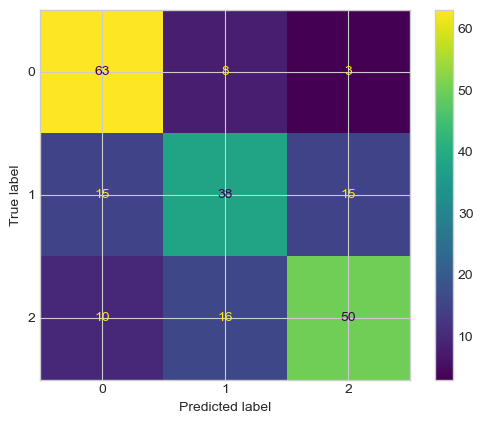

[14:43:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbo

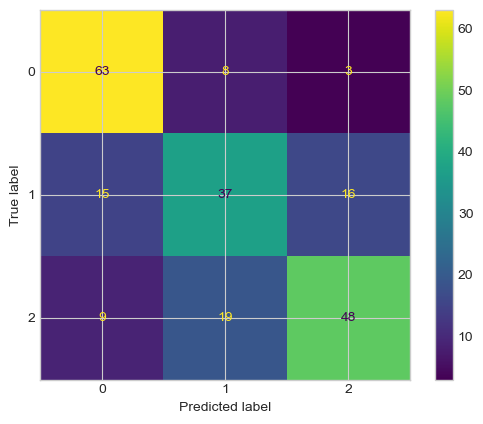

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(100, 50),
              max_iter=500) 
               precision    recall  f1-score   support

           0       0.69      0.88      0.77        74
           1       0.66      0.49      0.56        68
           2       0.74      0.72      0.73        76

    accuracy                           0.70       218
   macro avg       0.70      0.70      0.69       218
weighted avg       0.70      0.70      0.69       218




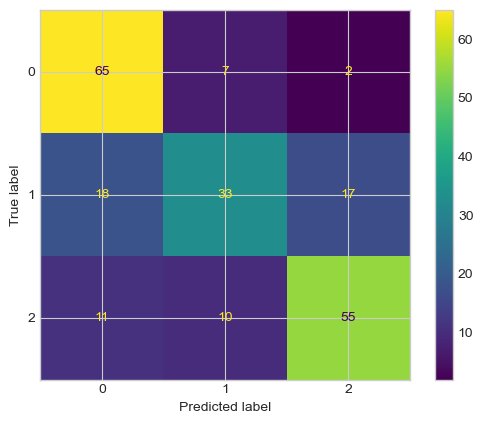

In [22]:
for m,model in enumerate(best_models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'{model} \n {classification_report(y_test, y_pred)}\n')
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    show()

In [23]:
best_model = KNeighborsClassifier(n_neighbors=15, weights='distance') 
best_model_cal_iso = CalibratedClassifierCV(best_model, method='isotonic')
best_model_cal_sig = CalibratedClassifierCV(best_model, method='sigmoid')
models = [best_model, best_model_cal_iso, best_model_cal_sig]        
labels = ['Uncalibrated', 'Isotonic', 'Sigmoid']
classes = ['12', '58', '34']
colors= ['r', 'g', 'b']

In [24]:
X_train, X_cal, y_train, y_cal = train_test_split(X, y, test_size=0.3, random_state=random_state+2)

for m, model in enumerate(models):
        model.fit(X_train, y_train)

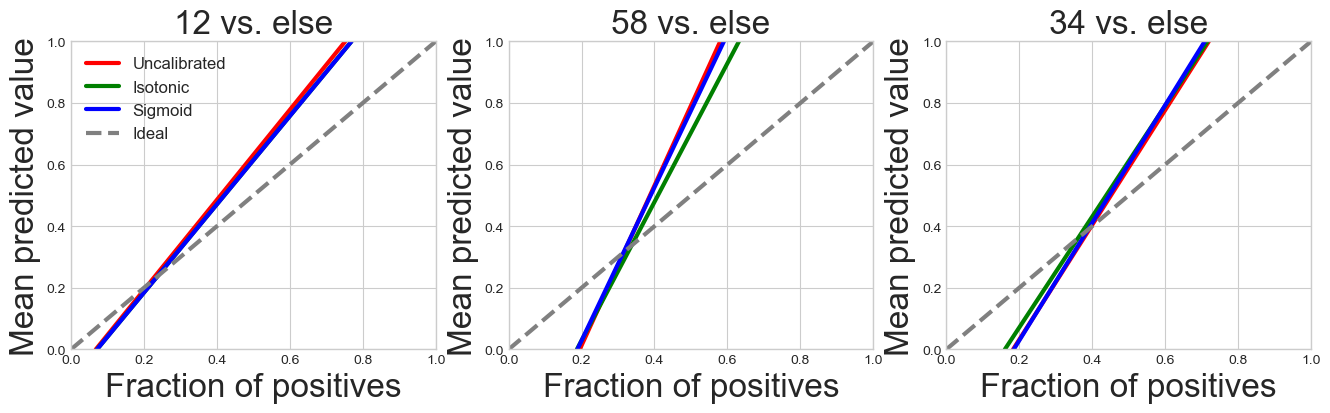

In [25]:
fig, axs = subplots(nrows=1, ncols=3, figsize=(16,4))

for i in range(3):
    for m, model in enumerate(models):
        y_pred = model.predict(X_cal)
        y_cal_b = np.vectorize(lambda x: 1 if x==i else 0)(y_cal)
        y_pred_b = np.vectorize(lambda x: 1 if x==i else 0)(y_pred)

        fop, mpv = calibration_curve(y_cal_b, (y_pred_b-y_pred_b.min())/y_pred_b.ptp(), n_bins=10)

        axs[i].plot(fop, mpv, color=colors[m], linestyle='-', linewidth=3, label=labels[m])


    axs[i].plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=3, label='Ideal')
    axs[i].set_xlim([0, 1])
    axs[i].set_ylim([0, 1])
    axs[i].set_xlabel('Fraction of positives', fontsize=24)
    axs[i].set_ylabel('Mean predicted value', fontsize=24)
    axs[i].set_title(f'{classes[i]} vs. else', fontsize=24)
    
    if i==0:
        axs[i].legend(loc='best' , fontsize=12)

show()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state+4)

for m, model in enumerate(models):
        model.fit(X_train, y_train)

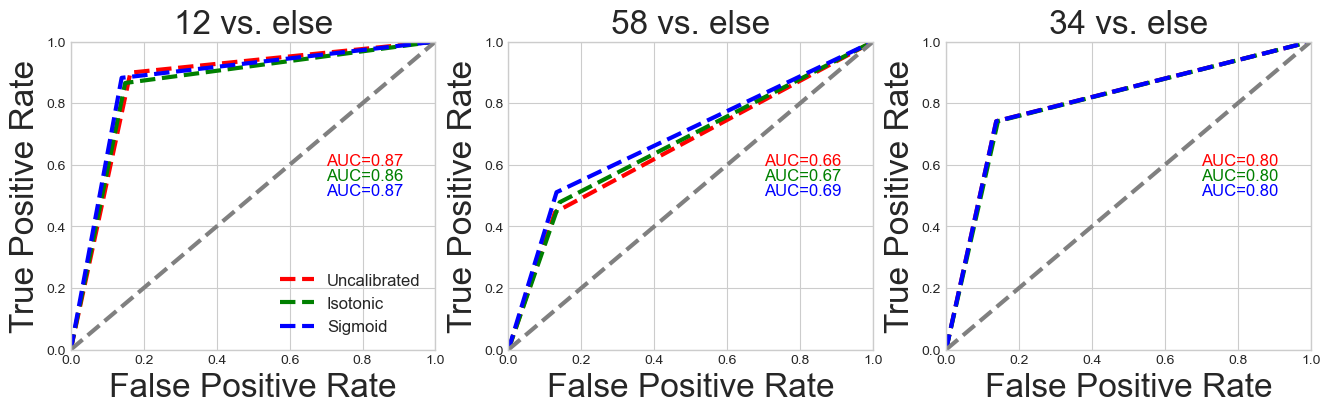

In [27]:
fig, axs = subplots(nrows=1, ncols=3, figsize=(16,4))

for i in range(3):
    for m, model in enumerate(models):
        y_pred = model.predict(X_test)
        y_test_b = np.vectorize(lambda x: 1 if x==i else 0)(y_test)
        y_pred_b = np.vectorize(lambda x: 1 if x==i else 0)(y_pred)

        fpr, tpr, thresholds = roc_curve(y_test_b, y_pred_b)

        axs[i].plot(fpr, tpr, color=colors[m], linestyle='--', linewidth=3, label=labels[m])
        axs[i].text(0.7, 0.6-0.05*m, f'AUC={auc(fpr, tpr):.2f}', color=colors[m], fontsize=12)

    axs[i].plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=3)
    axs[i].set_xlim([0, 1])
    axs[i].set_ylim([0, 1])
    axs[i].set_xlabel('False Positive Rate', fontsize=24)
    axs[i].set_ylabel('True Positive Rate', fontsize=24)
    axs[i].set_title(f'{classes[i]} vs. else', fontsize=24)
    

    if i==0:
        axs[i].legend(loc='best' , fontsize=12)
            
show()

In [28]:
X = df.iloc[:,3:]
y = df['Class']

In [29]:
best_model = RandomForestClassifier(criterion='log_loss', n_estimators=200)
best_model.fit(X, y)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X)

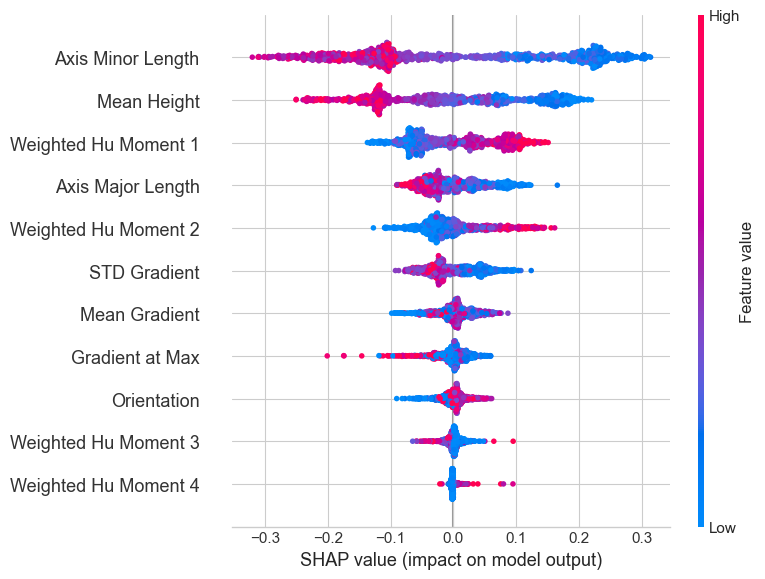

In [30]:
shap.summary_plot(shap_values[:,:,0], X, max_display=X.shape[1])

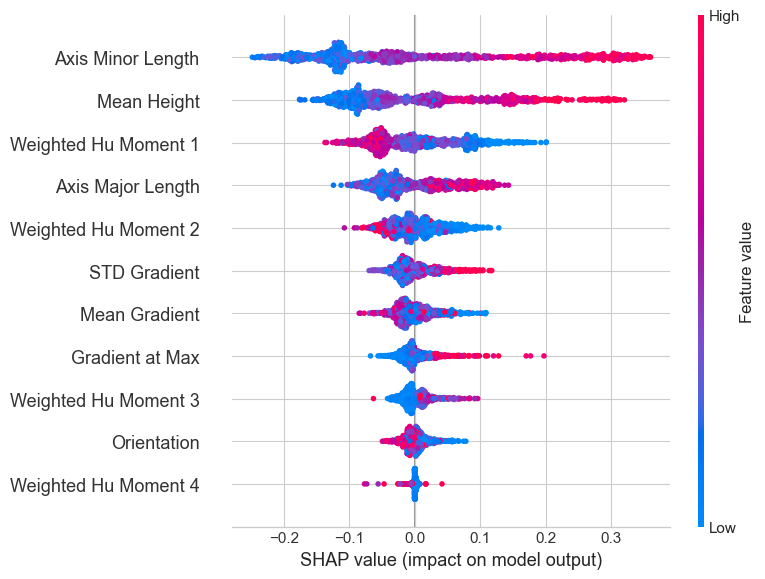

In [31]:
shap.summary_plot(shap_values[:,:,1], X, max_display=X.shape[1])

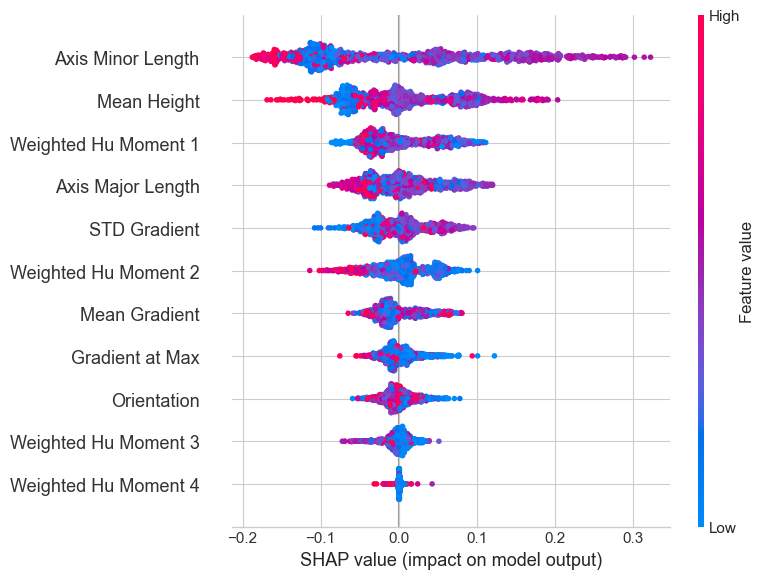

In [32]:
shap.summary_plot(shap_values[:,:,2], X, max_display=X.shape[1])

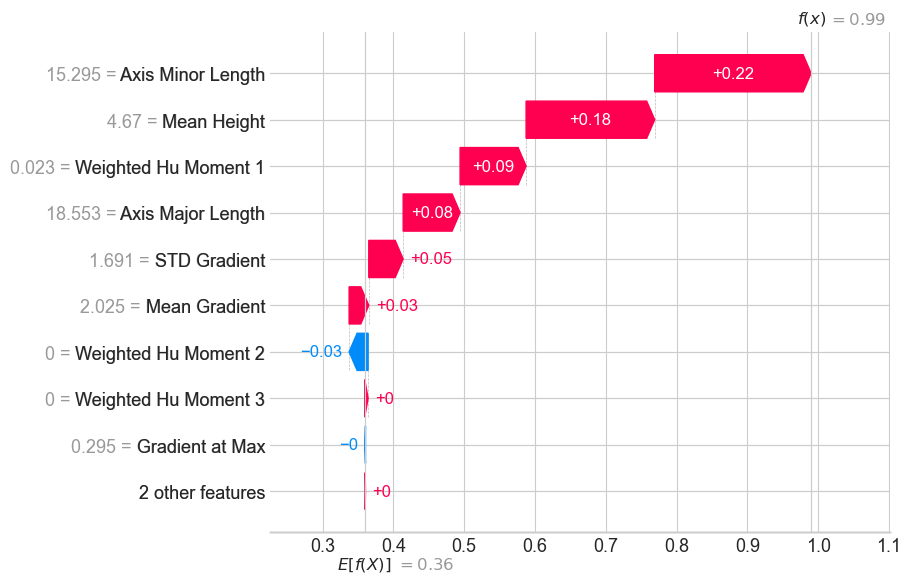

In [33]:
shap.plots.waterfall(shap_values[100,:,0])

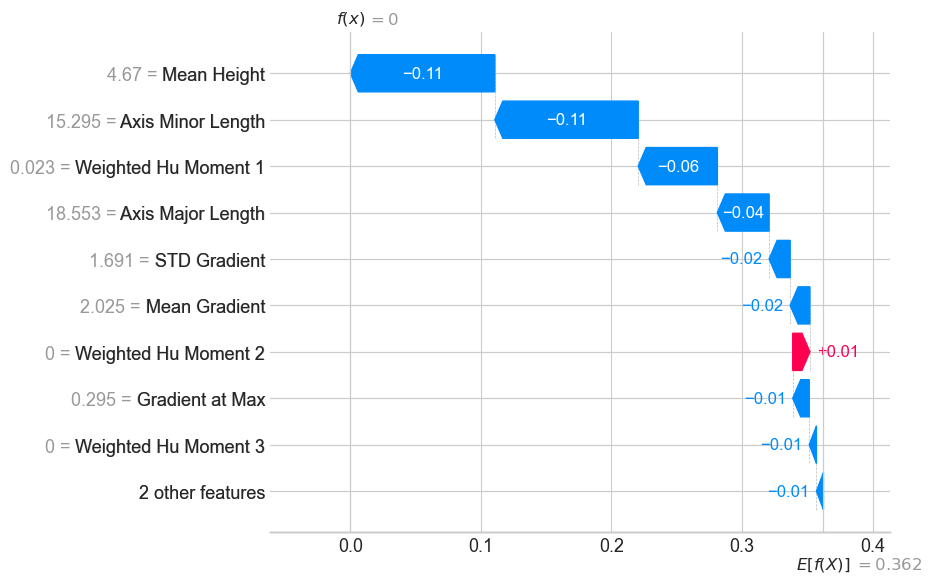

In [34]:
shap.plots.waterfall(shap_values[100,:,1])

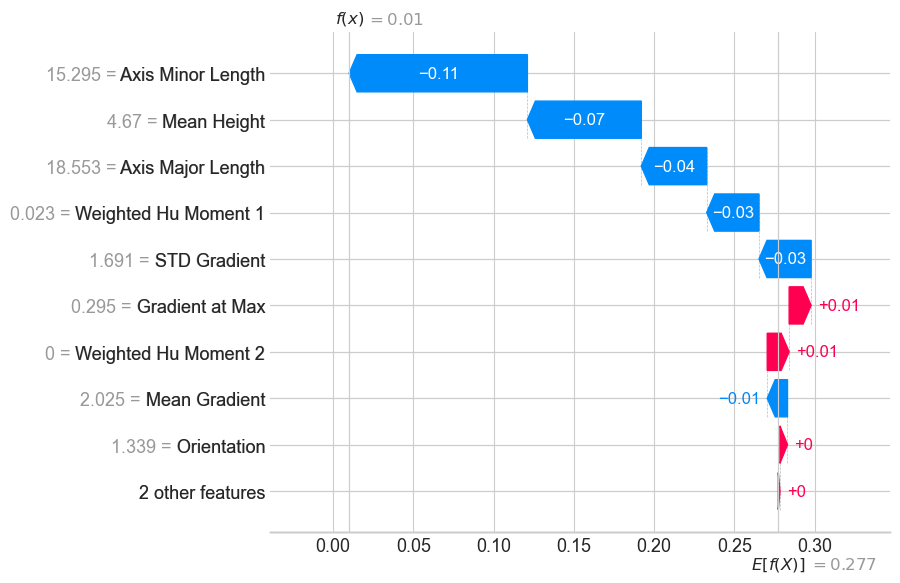

In [35]:
shap.plots.waterfall(shap_values[100,:,2])

In [36]:
X.columns

Index(['Orientation', 'Axis Major Length', 'Axis Minor Length', 'Mean Height',
       'Mean Gradient', 'STD Gradient', 'Gradient at Max',
       'Weighted Hu Moment 1', 'Weighted Hu Moment 2', 'Weighted Hu Moment 3',
       'Weighted Hu Moment 4'],
      dtype='object')

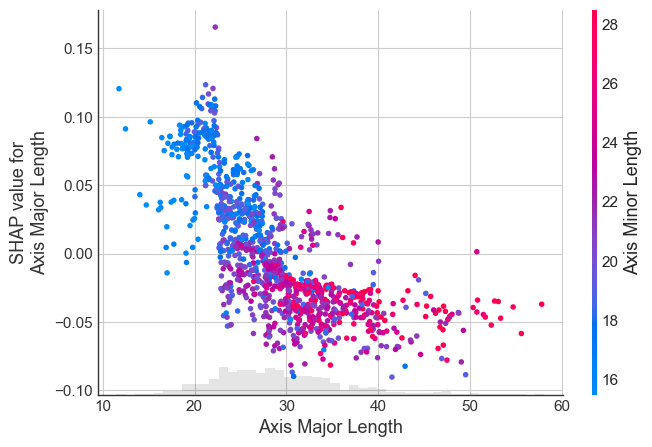

In [37]:
shap.plots.scatter(shap_values[:,1,0], color=shap_values[:,2,0])

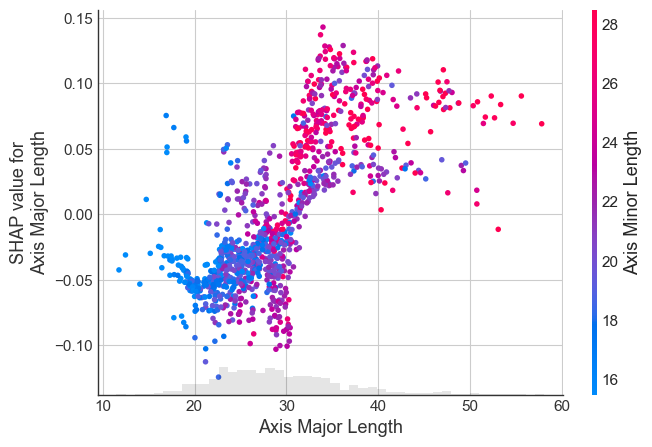

In [38]:
shap.plots.scatter(shap_values[:,1,1], color=shap_values[:,2,1])

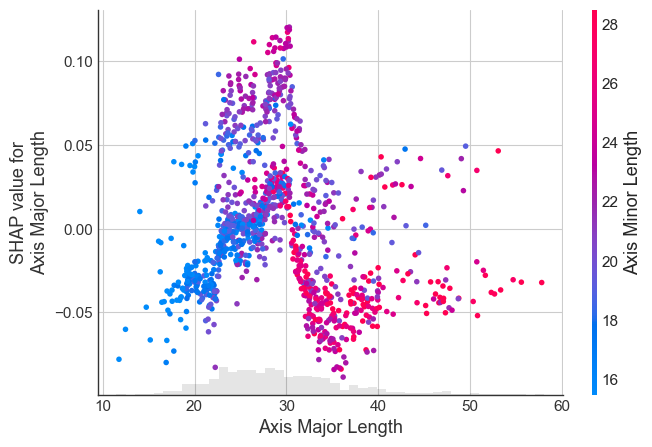

In [39]:
shap.plots.scatter(shap_values[:,1,2], color=shap_values[:,2,2])

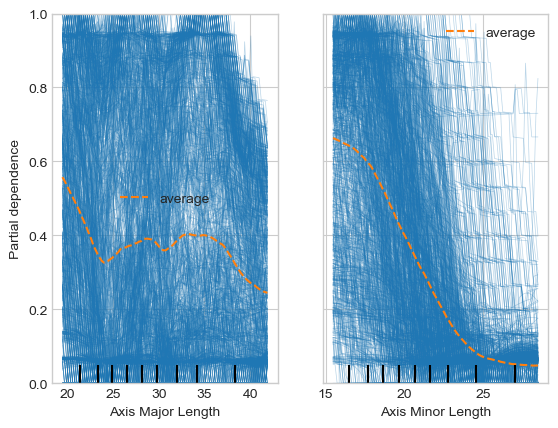

In [40]:
best_model = KNeighborsClassifier(n_neighbors=15, weights='distance')
best_model.fit(X, y)
features_PDP = ["Axis Major Length", "Axis Minor Length"]
PartialDependenceDisplay.from_estimator(best_model, X, features_PDP, kind='both', target=12)

In [ ]:
ale_eff = ale(X=X, model=best_model, feature=["Axis Minor Length"], grid_size=20, include_CI=False)

In [ ]:
ale_eff = ale(X=X, model=best_model, feature=features_PDP, grid_size=20, include_CI=False)

In [43]:
explainer = lime.lime_tabular.LimeTabularExplainer(X.to_numpy(), class_names=['12', '58', '34'], feature_names = X.columns, kernel_width=2, mode='classification')

In [44]:
i = np.random.randint(0, X.shape[0])
exp = explainer.explain_instance(X.iloc[i,:], best_model.predict_proba, num_features=X.shape[1], top_labels=1)
exp.save_to_file(f'original_lime_row{i}.html')

# Model training - change Mean height to Max Height (based on SHAP results)

In [45]:
df = pd.read_csv('../data/rock_data.csv')

# handle missing values
if df.isnull().values.any():
    df.fillna(df.mean(), inplace=True)
    print('Missing values filled with mean.')

# detect and remove outliers

# drop highly correlated features
df.drop(['Area', 'Perimeter','Median Height', 'Mean Height', 'STD Height'], axis=1, inplace=True)
df.columns

Index(['Sample ID', 'Rock ID', 'Class', 'Orientation', 'Axis Major Length',
       'Axis Minor Length', 'Max Height', 'Mean Gradient', 'STD Gradient',
       'Gradient at Max', 'Weighted Hu Moment 1', 'Weighted Hu Moment 2',
       'Weighted Hu Moment 3', 'Weighted Hu Moment 4'],
      dtype='object')

In [46]:
X = df.iloc[:,3:].to_numpy(dtype=float)

def map_class_values(x):
    mapping = {12: 0, 58: 1, 34: 2}
    return mapping.get(x,None)

y = np.vectorize(map_class_values)(df['Class'].values)

In [47]:
# training:validation:testing = 60:20:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)

In [48]:
model_names = ['KNN', 'SVC', 'RF', 'XGB', 'MLP']
models = [KNeighborsClassifier(), SVC(), RandomForestClassifier(), XGBClassifier(), MLPClassifier(max_iter=500)]
grid_params = [{'n_neighbors': [5, 10, 15, 20], 'weights': ['uniform', 'distance']}, {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'sigmoid']}, {'n_estimators': [10, 100, 200], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_features': ['sqrt', 'log2', None]}, {'max_depth': [3,5,7], 'n_estimators': [10, 100, 200], 'reg_lambda': [1e-3, 1, 1e3]}, {'hidden_layer_sizes': [(100,), (100,50), (100,50,100)], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'alpha': [1e-3, 1, 1e3]}]

KNN with {'n_neighbors': 20, 'weights': 'uniform'} 
               precision    recall  f1-score   support

           0       0.77      0.83      0.80        88
           1       0.44      0.43      0.43        54
           2       0.75      0.70      0.72        76

    accuracy                           0.68       218
   macro avg       0.65      0.65      0.65       218
weighted avg       0.68      0.68      0.68       218




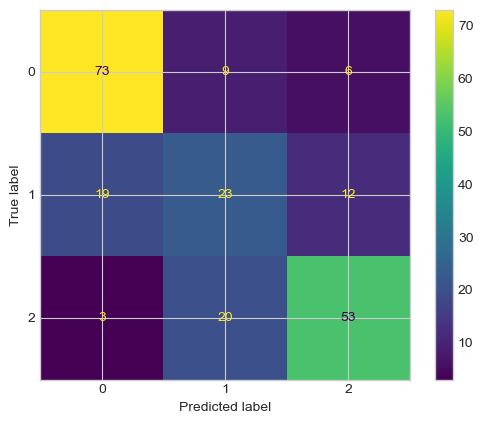

SVC with {'C': 0.1, 'kernel': 'linear'} 
               precision    recall  f1-score   support

           0       0.80      0.77      0.79        88
           1       0.49      0.57      0.53        54
           2       0.79      0.72      0.75        76

    accuracy                           0.71       218
   macro avg       0.69      0.69      0.69       218
weighted avg       0.72      0.71      0.71       218




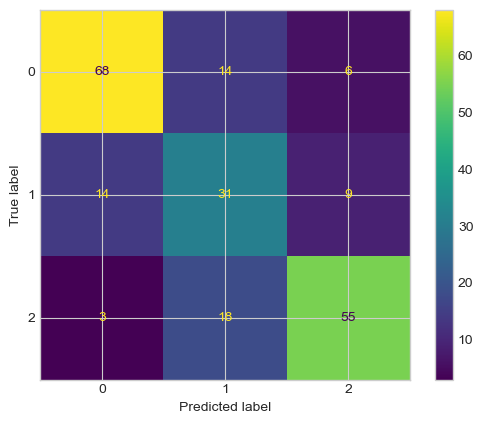

RF with {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 200} 
               precision    recall  f1-score   support

           0       0.80      0.82      0.81        88
           1       0.47      0.52      0.49        54
           2       0.75      0.67      0.71        76

    accuracy                           0.69       218
   macro avg       0.67      0.67      0.67       218
weighted avg       0.70      0.69      0.70       218




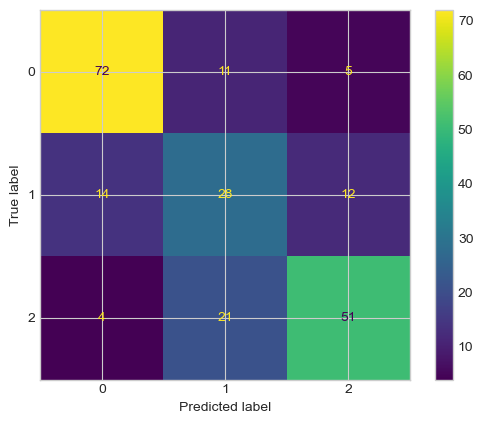

[14:45:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:45:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:45:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:45:29] WARNI

[14:45:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:45:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:45:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:45:34] WARNI

[14:45:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:45:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:45:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:45:43] WARNI

[14:45:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:45:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:45:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:45:52] WARNI

[14:46:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:46:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:46:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:46:01] WARNI

[14:46:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:46:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:46:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:46:13] WARNI

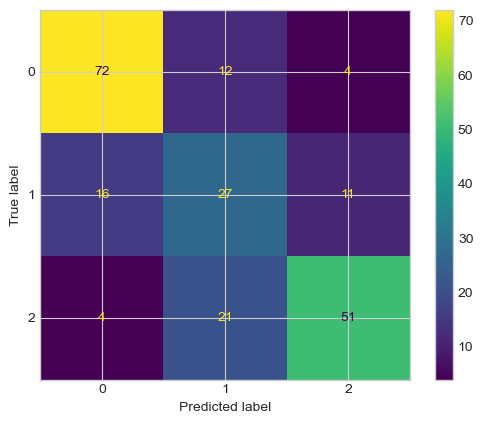

MLP with {'activation': 'tanh', 'alpha': 1, 'hidden_layer_sizes': (100, 50)} 
               precision    recall  f1-score   support

           0       0.66      0.91      0.77        88
           1       0.36      0.24      0.29        54
           2       0.80      0.64      0.72        76

    accuracy                           0.65       218
   macro avg       0.61      0.60      0.59       218
weighted avg       0.64      0.65      0.63       218




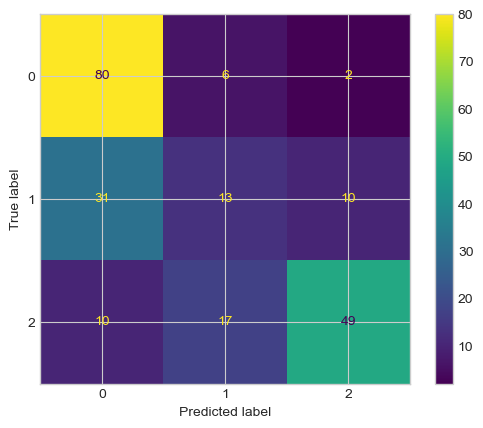

In [49]:
dataset = 'max_height'
opt_method = 'grid_search'
for m,model in enumerate(models):
    grid_search = GridSearchCV(model, grid_params[m], cv=5)
    grid_search.fit(X_train, y_train)
    model_best = grid_search.best_estimator_
    model_best_pred = model_best.predict(X_val)
    # Parse report to dataframe to compare results among models
#     if m==0:
#         results_df = parse_report(y_val, model_best_pred, m, model_names, grid_search, dataset)
#     else:
    df_i = parse_report(y_val, model_best_pred, m, model_names, grid_search, dataset, opt_method)
    results_df = pd.concat([results_df, df_i])
    # Print results
    print(f'{model_names[m]} with {grid_search.best_params_} \n {classification_report(y_val, model_best_pred)}\n')
    ConfusionMatrixDisplay(confusion_matrix(y_val, model_best_pred)).plot()
    show()

## Bayes Search Optimization

In [50]:
search_spaces = [{
    'n_neighbors': Integer(3,50),
    'weights': Categorical(['uniform', 'distance'])
    },
    
    {
    'C': Real(0.1, 10, 'log-uniform'),
    'kernel': Categorical(['linear', 'rbf', 'sigmoid']),
    },
    
    {
    'n_estimators': Integer(10,200),
    'criterion': Categorical(['gini', 'entropy', 'log_loss']),
    'max_features': Categorical(['sqrt', 'log2', None]),
    },
    
    {
    'max_depth': Integer(3,10),
    'n_estimators': Integer(10,200),
    'reg_lambda': Real(1e-3, 1e3, 'log-uniform'),
    }
    ]

KNN with OrderedDict([('n_neighbors', 27), ('weights', 'uniform')]) 
               precision    recall  f1-score   support

           0       0.76      0.82      0.79        88
           1       0.43      0.39      0.41        54
           2       0.73      0.71      0.72        76

    accuracy                           0.67       218
   macro avg       0.64      0.64      0.64       218
weighted avg       0.67      0.67      0.67       218




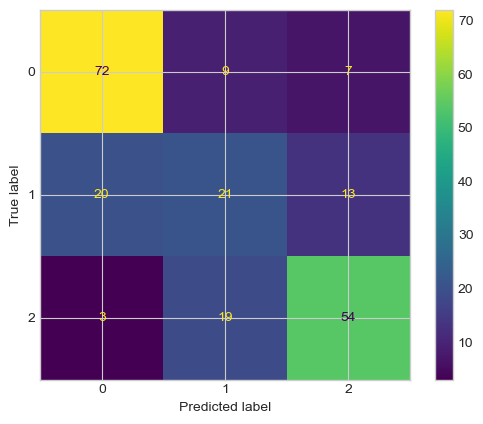

SVC with OrderedDict([('C', 0.17845021551905355), ('kernel', 'linear')]) 
               precision    recall  f1-score   support

           0       0.80      0.77      0.79        88
           1       0.49      0.57      0.53        54
           2       0.79      0.72      0.75        76

    accuracy                           0.71       218
   macro avg       0.69      0.69      0.69       218
weighted avg       0.72      0.71      0.71       218




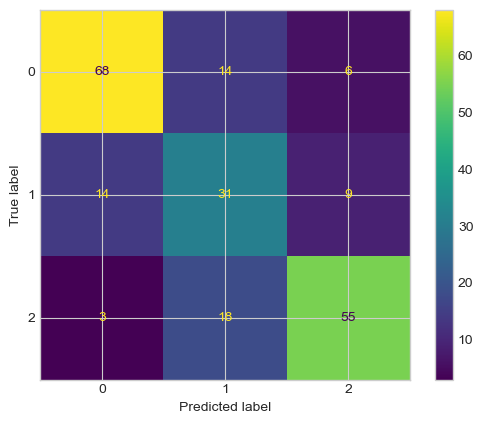

RF with OrderedDict([('criterion', 'log_loss'), ('max_features', 'log2'), ('n_estimators', 147)]) 
               precision    recall  f1-score   support

           0       0.79      0.80      0.79        88
           1       0.45      0.56      0.50        54
           2       0.79      0.64      0.71        76

    accuracy                           0.68       218
   macro avg       0.67      0.67      0.67       218
weighted avg       0.70      0.68      0.69       218




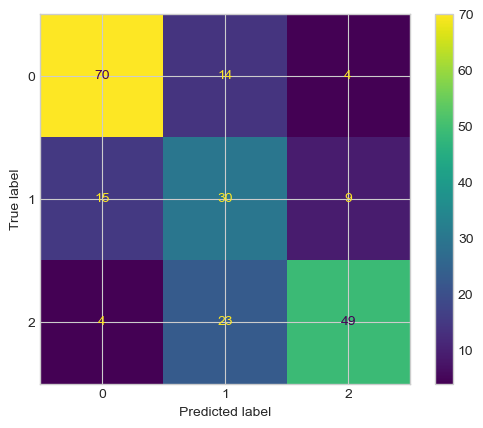

[14:57:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB with OrderedDict([('max_depth', 3), ('n_estimators', 198), ('reg_lambda', 0.012606743745526996)]) 
               precision    recall  f1-score   support

           0       0.79      0.82      0.80        88
           1       0.44      0.44      0.44        54
           2       0.75      0.71      0.73        76

    accuracy                           0.69       218
   macro avg       0.66      0.66      0.66       218
weighted avg       0.69      0.69      0.69       218




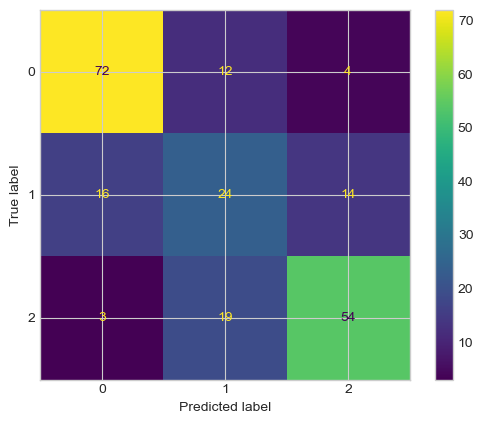

In [51]:
dataset = 'max_height'
opt_method = 'bayes_search'
for m,model in enumerate(models[:-1]):
    bayes_search = BayesSearchCV(model, search_spaces[m], n_iter=50, cv=5, n_jobs=-1)
    bayes_search.fit(X_train, y_train)
    model_best = bayes_search.best_estimator_
    model_best_pred = model_best.predict(X_val)
    # Parse report to dataframe to compare results among models
    df_i = parse_report(y_val, model_best_pred, m, model_names, bayes_search, dataset, opt_method)
    results_df = pd.concat([results_df, df_i])
    print(f'{model_names[m]} with {bayes_search.best_params_} \n {classification_report(y_val, model_best_pred)}\n')
    ConfusionMatrixDisplay(confusion_matrix(y_val, model_best_pred)).plot()
    show()

### Compare Model Results

In [52]:
results_df['opt_method_dataset']=results_df['opt_method']+'_'+results_df['dataset']

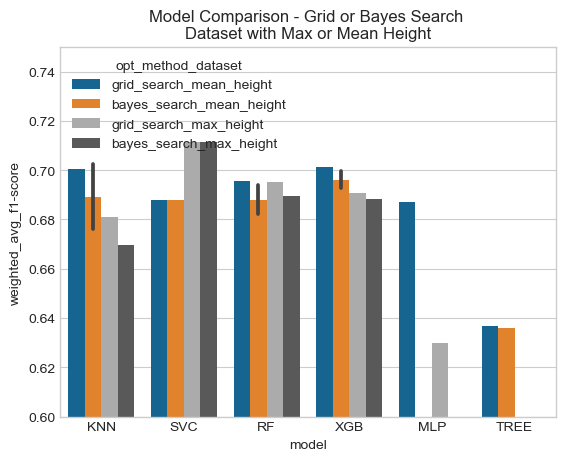

In [53]:
plt.title('Model Comparison - Grid or Bayes Search \nDataset with Max or Mean Height')
sns.barplot(x=results_df['model'], y=results_df['weighted_avg_f1-score'], hue=results_df['opt_method_dataset'])
plt.ylim(0.6, 0.75)
plt.show()

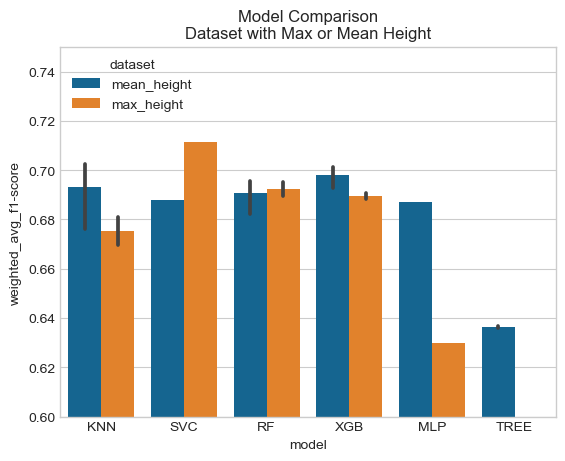

In [54]:
plt.title('Model Comparison\nDataset with Max or Mean Height')
sns.barplot(x=results_df['model'], y=results_df['weighted_avg_f1-score'], hue=results_df['dataset'])
plt.ylim(0.6, 0.75)
plt.show()

# SHAP Values

In [55]:
df = pd.read_csv('../data/rock_data.csv')

# handle missing values
if df.isnull().values.any():
    df.fillna(df.mean(), inplace=True)
    print('Missing values filled with mean.')

# detect and remove outliers

# drop highly correlated features
df.drop(['Area', 'Perimeter','Median Height', 'Mean Height', 'STD Height'], axis=1, inplace=True)
df.columns

X = df.iloc[:,3:]#.to_numpy(dtype=float)
y = df['Class'].values #np.vectorize(map_class_values)(df['Class'].values)

In [56]:
# Best model - from plot
model_mask = (results_df['model']=='RF')
dataset_mask = (results_df['dataset']=='max_height')
opt_method_mask = (results_df['opt_method']=='grid_search')
mask = model_mask & dataset_mask & opt_method_mask
params_best_model = results_df['params'][mask].values[0]
results_df[mask]

model                                             params     dataset  \
2    RF  {'criterion': 'entropy', 'max_features': 'log2...  max_height   

    opt_method  class_0_precision  class_0_recall  class_0_f1-score  \
2  grid_search                0.8        0.818182          0.808989   

   class_0_support  class_1_precision  class_1_recall  ...  accuracy  \
2               88           0.466667        0.518519  ...        76   

   macro_avg_precision  macro_avg_recall  macro_avg_f1-score  \
2             0.672222          0.669251            0.669517   

   macro_avg_support  weighted_avg_precision  weighted_avg_recall  \
2                218                     0.7             0.692661   

   weighted_avg_f1-score  weighted_avg_support      opt_method_dataset  
2               0.695187                   218  grid_search_max_height  

[1 rows x 26 columns]

In [57]:
params_best_model

{'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 200}

In [58]:
# best_model = SVC(C= params_best_model['C'], kernel= params_best_model['kernel'])
best_model = RandomForestClassifier(criterion= params_best_model['criterion'], 
                                    max_features= params_best_model['max_features'], 
                                    n_estimators= params_best_model['n_estimators'])
best_model.fit(X_train, y_train)

# svm_explainer = shap.KernelExplainer(best_model.predict,X_test)
# svm_shap_values = svm_explainer.shap_values(X_test)

explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X)

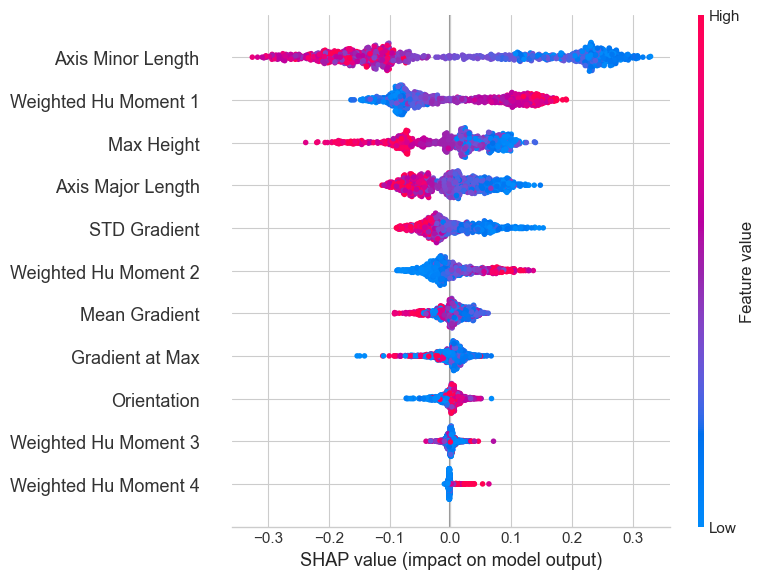

In [59]:
shap.summary_plot(shap_values[:,:,0], X, max_display=X.shape[1])

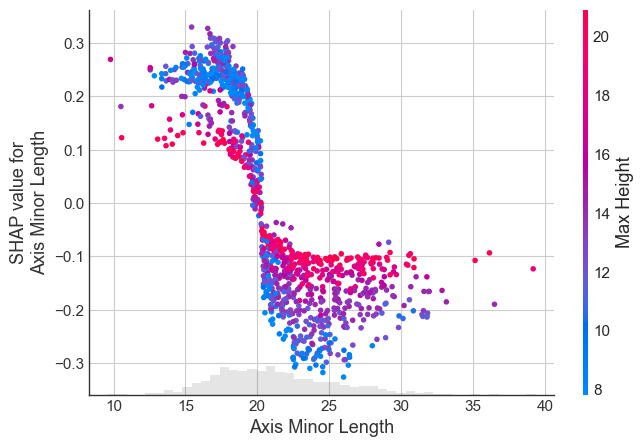

<Figure size 640x480 with 0 Axes>

In [60]:
shap.plots.scatter(shap_values[:,2,0], color=shap_values[:,3,0])
save_plot('shap_scatter_minor len vs max H_class 0')

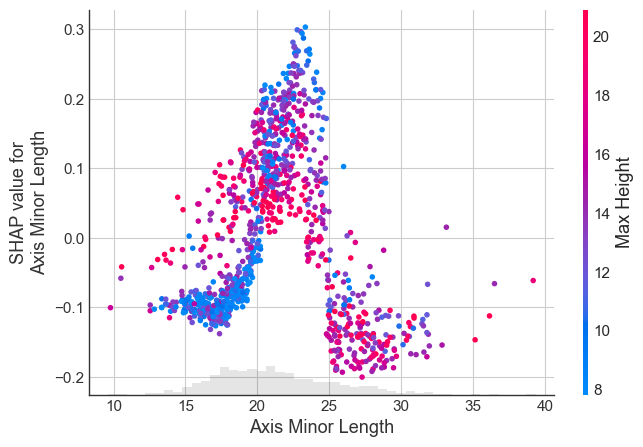

<Figure size 640x480 with 0 Axes>

In [61]:
shap.plots.scatter(shap_values[:,2,1], color=shap_values[:,3,1])
save_plot('shap_scatter_minor len vs max H_class 1')

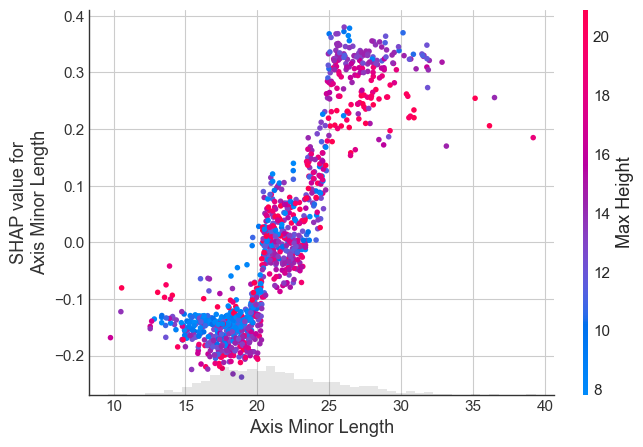

<Figure size 640x480 with 0 Axes>

In [62]:
shap.plots.scatter(shap_values[:,2,2], color=shap_values[:,3,2])
save_plot('shap_scatter_minor len vs max H_class 2')

# Partial dependence plots

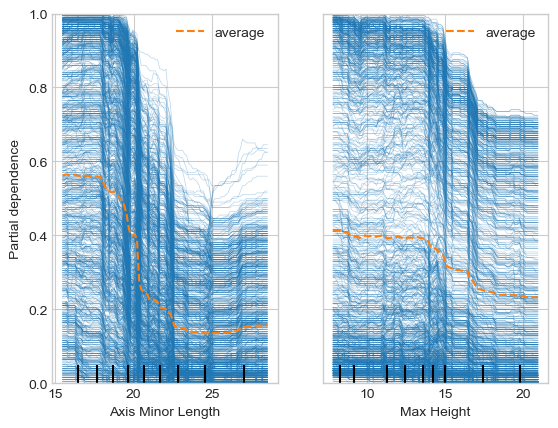

In [63]:
# best_model = KNeighborsClassifier(n_neighbors=15, weights='distance')
# best_model.fit(X, y)
features_PDP = ["Axis Minor Length", "Max Height"]
PartialDependenceDisplay.from_estimator(best_model, X, features_PDP, kind='both', target=0)
save_plot('pdp_axis minor len_class 0')

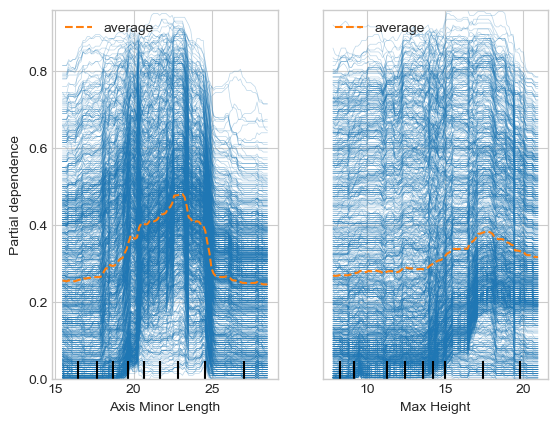

In [64]:
features_PDP = ["Axis Minor Length", "Max Height"]
PartialDependenceDisplay.from_estimator(best_model, X, features_PDP, kind='both', target=1)
save_plot('pdp_axis minor len_class 1')

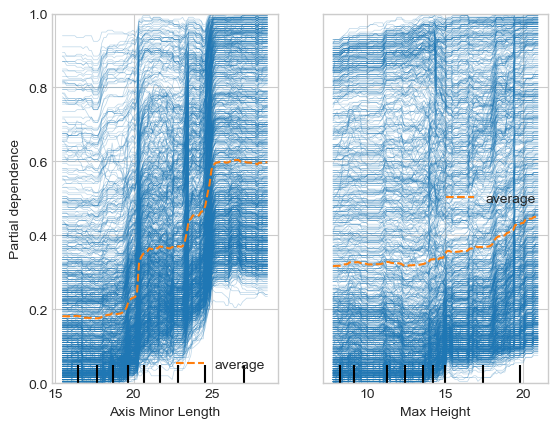

In [65]:
features_PDP = ["Axis Minor Length", "Max Height"]
PartialDependenceDisplay.from_estimator(best_model, X, features_PDP, kind='both', target=2)
save_plot('pdp_axis minor len_class 2')

# Instance - Waterfall

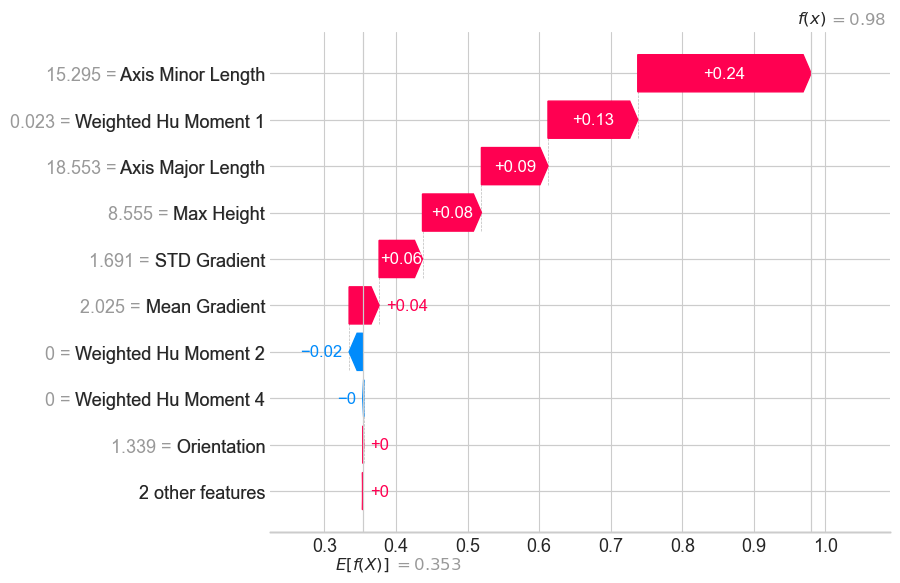

In [66]:
shap.plots.waterfall(shap_values[100,:,0])

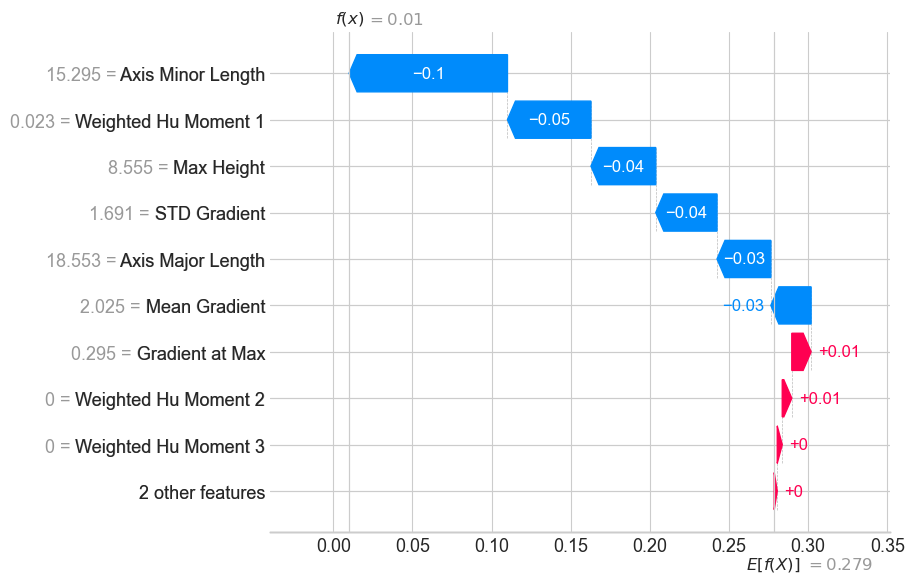

In [67]:
shap.plots.waterfall(shap_values[100,:,1])

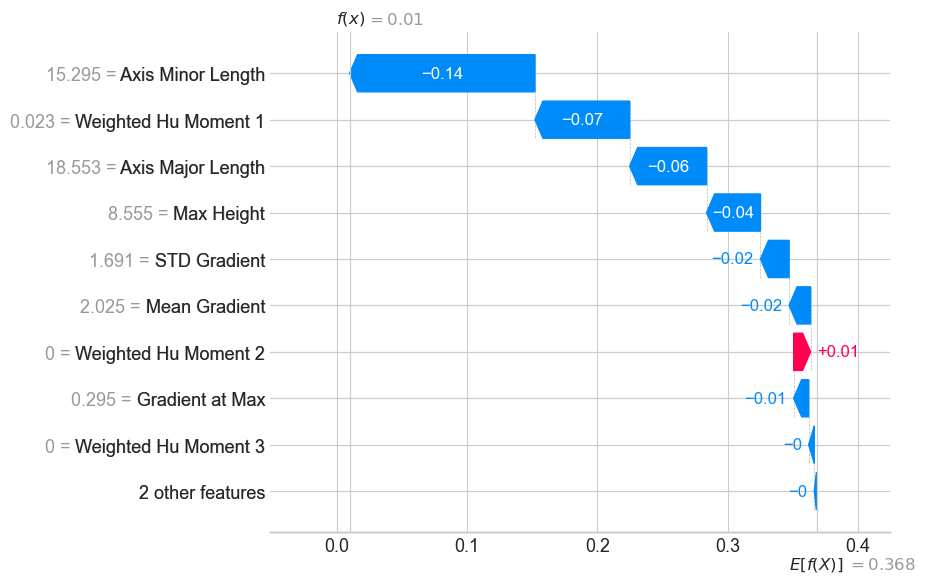

In [68]:
shap.plots.waterfall(shap_values[100,:,2])

In [69]:
results_df.to_csv('models_performance.csv')

PermissionError: [Errno 13] Permission denied: 'models_performance.csv'